#Quais variáveis influenciam o retorno de um ativo a curto prazo?

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score


In [131]:
df = pd.read_csv('/content/all_stocks_5yr.csv')
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [132]:
#Vendo a quantidade de linhas e colunas tem o dataframe
df.shape

(619040, 7)

In [133]:
#Vendo a quantidade de elementos do dataframe
df.size

4333280

In [134]:
#Vendo a dimensão do dataframe
df.ndim

2

In [135]:
#Verificando o tipo dos dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


##Tratando dados faltantes

In [136]:
#Verificando os dados faltantes do dataset
df.isnull().sum()

,0
date,0
open,11
high,8
low,8
close,0
volume,0
Name,0


In [137]:
#tratando os dados faltantes com a média dos preços anteriores e seguintes
df['open'] = df['open'].interpolate(method='linear')
df['high'] = df['high'].interpolate(method='linear')
df['low'] = df['low'].interpolate(method='linear')

In [138]:
df.isnull().sum()

,0
date,0
open,0
high,0
low,0
close,0
volume,0
Name,0


##Criando features

In [139]:
#Criando as colunas de datas
df['year'] = pd.DatetimeIndex(df['date']).year
df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date'].dt.dayofweek  # 0 = segunda, 4 = sexta
df['month'] = df['date'].dt.month
df['days_since_start'] = (df['date'] - df['date'].min()).dt.days
df

,date,open,high,low,close,volume,Name,year,day_of_week,month,days_since_start
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL,2013,4,2,0
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL,2013,0,2,3
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL,2013,1,2,4
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL,2013,2,2,5
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL,2013,3,2,6
...,...,...,...,...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS,2018,3,2,1819
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS,2018,4,2,1820
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS,2018,0,2,1823
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS,2018,1,2,1824


In [140]:
#Criando coluna de média movel exponencial
df['EMA14'] = df.groupby('Name')['close'].transform(lambda x: x.ewm(span=14, adjust=False).mean())

#Criando coluna de Rolling média e desvio padrão de 5 dias
df['rolling_mean_5'] = df.groupby('Name')['close'].transform(lambda x: x.rolling(window=5).mean())
df['rolling_std_5'] = df.groupby('Name')['close'].transform(lambda x: x.rolling(window=5).std())

#Criando coluna de Rolling média e desvio padrão de 14 dias
df['rolling_mean_14'] = df.groupby('Name')['close'].transform(lambda x: x.rolling(window=14).mean())
df['rolling_std_14'] = df.groupby('Name')['close'].transform(lambda x: x.rolling(window=14).std())

df.head(30)

,date,open,high,low,close,volume,Name,year,day_of_week,month,days_since_start,EMA14,rolling_mean_5,rolling_std_5,rolling_mean_14,rolling_std_14
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL,2013,4,2,0,14.750000,NaN,NaN,NaN,NaN
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL,2013,0,2,3,14.711333,NaN,NaN,NaN,NaN
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL,2013,1,2,4,14.652489,NaN,NaN,NaN,NaN
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL,2013,2,2,5,14.653490,NaN,NaN,NaN,NaN
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL,2013,3,2,6,14.565025,14.426,0.306317,NaN,NaN
5,2013-02-15,13.93,14.61,13.93,14.50,15628000,AAL,2013,4,2,7,14.556355,14.376,0.256574,NaN,NaN
6,2013-02-19,14.33,14.56,14.08,14.26,11354400,AAL,2013,1,2,11,14.516841,14.336,0.255793,NaN,NaN
7,2013-02-20,14.17,14.26,13.15,13.33,14725200,AAL,2013,2,2,12,14.358596,14.148,0.522657,NaN,NaN
8,2013-02-21,13.62,13.95,12.90,13.37,11922100,AAL,2013,3,2,13,14.226783,13.890,0.525119,NaN,NaN
9,2013-02-22,13.57,13.60,13.21,13.57,6071400,AAL,2013,4,2,14,14.139212,13.806,0.538544,NaN,NaN


In [141]:
#Criando coluna de retorno, o que diz que diz se a ação valorizou ou não de um dia para o outro, e a coluna de retorno em % para saber quanto foi essa valorização/desvalorização
df['return'] = df.groupby('Name')['close'].pct_change()
df['return (%)'] = df.groupby('Name')['close'].pct_change()*100
#Essa coluna representará o retorno do dia anterior, servirá para o modelo que será criado futuramente análisar os padrões
df['return_shifted'] = df.groupby('Name')['return (%)'].shift(1)
df

,date,open,high,low,close,volume,Name,year,day_of_week,month,days_since_start,EMA14,rolling_mean_5,rolling_std_5,rolling_mean_14,rolling_std_14,return,return (%),return_shifted
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL,2013,4,2,0,14.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL,2013,0,2,3,14.711333,NaN,NaN,NaN,NaN,-0.019661,-1.966102,NaN
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL,2013,1,2,4,14.652489,NaN,NaN,NaN,NaN,-0.013140,-1.313970,-1.966102
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL,2013,2,2,5,14.653490,NaN,NaN,NaN,NaN,0.027330,2.733006,-1.313970
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL,2013,3,2,6,14.565025,14.426,0.306317,NaN,NaN,-0.045703,-4.570259,2.733006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS,2018,3,2,1819,77.289534,78.434,1.283211,77.533571,1.405000,0.014206,1.420566,-2.067645
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS,2018,4,2,1820,77.221596,77.772,1.047459,77.632857,1.285938,-0.013364,-1.336417,1.420566
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS,2018,0,2,1823,76.769383,76.702,1.747933,77.510714,1.553410,-0.038421,-3.842146,-1.336417
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS,2018,1,2,1824,76.302799,75.686,2.007643,77.260714,1.920138,-0.007585,-0.758499,-3.842146


In [142]:
#Calcula o RSI (Relative Strength Index), indicador técnico usado para medir a força do movimento de preço
#Vai ser usado como feature para ajudar o modelo a identificar possíveis pontos de reversão (sobrecompra/sobrevenda)
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [143]:
df['RSI_14'] = df.groupby('Name')['close'].transform(lambda x: calculate_rsi(x))
df

,date,open,high,low,close,volume,Name,year,day_of_week,month,days_since_start,EMA14,rolling_mean_5,rolling_std_5,rolling_mean_14,rolling_std_14,return,return (%),return_shifted,RSI_14
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL,2013,4,2,0,14.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL,2013,0,2,3,14.711333,NaN,NaN,NaN,NaN,-0.019661,-1.966102,NaN,NaN
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL,2013,1,2,4,14.652489,NaN,NaN,NaN,NaN,-0.013140,-1.313970,-1.966102,NaN
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL,2013,2,2,5,14.653490,NaN,NaN,NaN,NaN,0.027330,2.733006,-1.313970,NaN
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL,2013,3,2,6,14.565025,14.426,0.306317,NaN,NaN,-0.045703,-4.570259,2.733006,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS,2018,3,2,1819,77.289534,78.434,1.283211,77.533571,1.405000,0.014206,1.420566,-2.067645,64.912281
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS,2018,4,2,1820,77.221596,77.772,1.047459,77.632857,1.285938,-0.013364,-1.336417,1.420566,56.278229
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS,2018,0,2,1823,76.769383,76.702,1.747933,77.510714,1.553410,-0.038421,-3.842146,-1.336417,43.835616
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS,2018,1,2,1824,76.302799,75.686,2.007643,77.260714,1.920138,-0.007585,-0.758499,-3.842146,36.742424


In [144]:
#Criando coluna de volatilidade, para sabermos a volatilidade dos ativos nos ultimos 5 dias
#Como nao temos dados para calcular os dados iniciais, acabam sendo criados dados faltantes, vou trata-los usando o metodo fill que usa o primeiro valor válido da volatilidade e copia para os NaNs anteriores, mantendo a coerencia temporal
df['volatility'] = df.groupby('Name')['return'].rolling(window=5).std().reset_index(level=0, drop=True).fillna(method='ffill')
df.head(10)

<ipython-input-144-5478e1d7ab06>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['volatility'] = df.groupby('Name')['return'].rolling(window=5).std().reset_index(level=0, drop=True).fillna(method='ffill')


,date,open,high,low,close,volume,Name,year,day_of_week,month,...,EMA14,rolling_mean_5,rolling_std_5,rolling_mean_14,rolling_std_14,return,return (%),return_shifted,RSI_14,volatility
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL,2013,4,2,...,14.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.017841
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL,2013,0,2,...,14.711333,NaN,NaN,NaN,NaN,-0.019661,-1.966102,NaN,NaN,0.017841
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL,2013,1,2,...,14.652489,NaN,NaN,NaN,NaN,-0.013140,-1.313970,-1.966102,NaN,0.017841
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL,2013,2,2,...,14.653490,NaN,NaN,NaN,NaN,0.027330,2.733006,-1.313970,NaN,0.017841
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL,2013,3,2,...,14.565025,14.426,0.306317,NaN,NaN,-0.045703,-4.570259,2.733006,NaN,0.017841
5,2013-02-15,13.93,14.61,13.93,14.50,15628000,AAL,2013,4,2,...,14.556355,14.376,0.256574,NaN,NaN,0.036455,3.645461,-4.570259,NaN,0.034207
6,2013-02-19,14.33,14.56,14.08,14.26,11354400,AAL,2013,1,2,...,14.516841,14.336,0.255793,NaN,NaN,-0.016552,-1.655172,3.645461,NaN,0.033854
7,2013-02-20,14.17,14.26,13.15,13.33,14725200,AAL,2013,2,2,...,14.358596,14.148,0.522657,NaN,NaN,-0.065217,-6.521739,-1.655172,NaN,0.044387
8,2013-02-21,13.62,13.95,12.90,13.37,11922100,AAL,2013,3,2,...,14.226783,13.890,0.525119,NaN,NaN,0.003001,0.300075,-6.521739,NaN,0.040014
9,2013-02-22,13.57,13.60,13.21,13.57,6071400,AAL,2013,4,2,...,14.139212,13.806,0.538544,NaN,NaN,0.014959,1.495886,0.300075,NaN,0.038533


In [145]:
df.isnull().sum()

,0
date,0
open,0
high,0
low,0
close,0
volume,0
Name,0
year,0
day_of_week,0
month,0


In [146]:
#Ao ser calculado os valores de retornos, criamos nans para o primeiro dia, pois não tinha como pegar o preço anterior ao primeiro dia
#Estou tratando esses dados faltantes, excluindo a linha pois nao seria util nesse caso
df.dropna(inplace=True)
df.isna().sum()

,0
date,0
open,0
high,0
low,0
close,0
volume,0
Name,0
year,0
day_of_week,0
month,0


In [151]:
df.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'Name', 'year',
       'day_of_week', 'month', 'days_since_start', 'EMA14', 'rolling_mean_5',
       'rolling_std_5', 'rolling_mean_14', 'rolling_std_14', 'return',
       'return (%)', 'return_shifted', 'RSI_14', 'volatility',
       'diff_close_ema14', 'log_volume', 'target'],
      dtype='object')

In [148]:
#Criando uma nova coluna com a diferença entre o preço de fechamento e a EMA14
df['diff_close_ema14'] = df['close'] - df['EMA14']
df

,date,open,high,low,close,volume,Name,year,day_of_week,month,...,rolling_mean_5,rolling_std_5,rolling_mean_14,rolling_std_14,return,return (%),return_shifted,RSI_14,volatility,diff_close_ema14
13,2013-02-28,13.49,13.63,13.39,13.43,6143600,AAL,2013,3,2,...,13.338,0.208974,13.877143,0.594894,0.001491,0.149142,1.131222,35.067873,0.024135,-0.345192
14,2013-03-01,13.37,13.95,13.32,13.61,7376800,AAL,2013,4,3,...,13.346,0.220522,13.795714,0.541887,0.013403,1.340283,0.149142,37.608696,0.023922,-0.143167
15,2013-03-04,13.50,14.07,13.47,13.90,8174800,AAL,2013,0,3,...,13.522,0.245092,13.755714,0.508735,0.021308,2.130786,1.340283,43.913043,0.007646,0.127256
16,2013-03-05,14.01,14.05,13.71,14.05,7676100,AAL,2013,1,3,...,13.680,0.285307,13.740000,0.494835,0.010791,1.079137,2.130786,47.587719,0.007078,0.240288
17,2013-03-06,14.52,14.68,14.25,14.57,13243200,AAL,2013,2,3,...,13.912,0.440363,13.733571,0.482392,0.037011,3.701068,1.079137,49.040512,0.013330,0.658916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS,2018,3,2,...,78.434,1.283211,77.533571,1.405000,0.014206,1.420566,-2.067645,64.912281,0.015148,0.530466
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS,2018,4,2,...,77.772,1.047459,77.632857,1.285938,-0.013364,-1.336417,1.420566,56.278229,0.013224,-0.441596
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS,2018,0,2,...,76.702,1.747933,77.510714,1.553410,-0.038421,-3.842146,-1.336417,43.835616,0.019033,-2.939383
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS,2018,1,2,...,75.686,2.007643,77.260714,1.920138,-0.007585,-0.758499,-3.842146,36.742424,0.019201,-3.032799


In [149]:
#Aplicando transformação logaritima na coluna de volume
df['log_volume'] = np.log1p(df['volume'])
df

,date,open,high,low,close,volume,Name,year,day_of_week,month,...,rolling_std_5,rolling_mean_14,rolling_std_14,return,return (%),return_shifted,RSI_14,volatility,diff_close_ema14,log_volume
13,2013-02-28,13.49,13.63,13.39,13.43,6143600,AAL,2013,3,2,...,0.208974,13.877143,0.594894,0.001491,0.149142,1.131222,35.067873,0.024135,-0.345192,15.630922
14,2013-03-01,13.37,13.95,13.32,13.61,7376800,AAL,2013,4,3,...,0.220522,13.795714,0.541887,0.013403,1.340283,0.149142,37.608696,0.023922,-0.143167,15.813851
15,2013-03-04,13.50,14.07,13.47,13.90,8174800,AAL,2013,0,3,...,0.245092,13.755714,0.508735,0.021308,2.130786,1.340283,43.913043,0.007646,0.127256,15.916567
16,2013-03-05,14.01,14.05,13.71,14.05,7676100,AAL,2013,1,3,...,0.285307,13.740000,0.494835,0.010791,1.079137,2.130786,47.587719,0.007078,0.240288,15.853622
17,2013-03-06,14.52,14.68,14.25,14.57,13243200,AAL,2013,2,3,...,0.440363,13.733571,0.482392,0.037011,3.701068,1.079137,49.040512,0.013330,0.658916,16.398995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS,2018,3,2,...,1.283211,77.533571,1.405000,0.014206,1.420566,-2.067645,64.912281,0.015148,0.530466,14.908192
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS,2018,4,2,...,1.047459,77.632857,1.285938,-0.013364,-1.336417,1.420566,56.278229,0.013224,-0.441596,14.769170
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS,2018,0,2,...,1.747933,77.510714,1.553410,-0.038421,-3.842146,-1.336417,43.835616,0.019033,-2.939383,14.901386
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS,2018,1,2,...,2.007643,77.260714,1.920138,-0.007585,-0.758499,-3.842146,36.742424,0.019201,-3.032799,15.409698


In [150]:
#Criando a variavel alvo, onde será 1 se a ação valorizou e 0 se ela desvalorizou ou se manteve estavel
df['target'] = df.groupby('Name')['return (%)'].shift(-1)
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)
df

,date,open,high,low,close,volume,Name,year,day_of_week,month,...,rolling_mean_14,rolling_std_14,return,return (%),return_shifted,RSI_14,volatility,diff_close_ema14,log_volume,target
13,2013-02-28,13.49,13.63,13.39,13.43,6143600,AAL,2013,3,2,...,13.877143,0.594894,0.001491,0.149142,1.131222,35.067873,0.024135,-0.345192,15.630922,1
14,2013-03-01,13.37,13.95,13.32,13.61,7376800,AAL,2013,4,3,...,13.795714,0.541887,0.013403,1.340283,0.149142,37.608696,0.023922,-0.143167,15.813851,1
15,2013-03-04,13.50,14.07,13.47,13.90,8174800,AAL,2013,0,3,...,13.755714,0.508735,0.021308,2.130786,1.340283,43.913043,0.007646,0.127256,15.916567,1
16,2013-03-05,14.01,14.05,13.71,14.05,7676100,AAL,2013,1,3,...,13.740000,0.494835,0.010791,1.079137,2.130786,47.587719,0.007078,0.240288,15.853622,1
17,2013-03-06,14.52,14.68,14.25,14.57,13243200,AAL,2013,2,3,...,13.733571,0.482392,0.037011,3.701068,1.079137,49.040512,0.013330,0.658916,16.398995,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS,2018,3,2,...,77.533571,1.405000,0.014206,1.420566,-2.067645,64.912281,0.015148,0.530466,14.908192,0
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS,2018,4,2,...,77.632857,1.285938,-0.013364,-1.336417,1.420566,56.278229,0.013224,-0.441596,14.769170,0
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS,2018,0,2,...,77.510714,1.553410,-0.038421,-3.842146,-1.336417,43.835616,0.019033,-2.939383,14.901386,0
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS,2018,1,2,...,77.260714,1.920138,-0.007585,-0.758499,-3.842146,36.742424,0.019201,-3.032799,15.409698,1


##Visualizando os dados

In [45]:
#Calculando a valorização desse periodo
valorizacao = sum(df[df['return (%)'] > 0]['return (%)'])
valorizacao

342686.7812108085

In [46]:
#Calculando a desvalorizacao do periodo
desvalorizacao = sum(df[df['return (%)'] < 0]['return (%)'])
desvalorizacao

-309133.67823743366

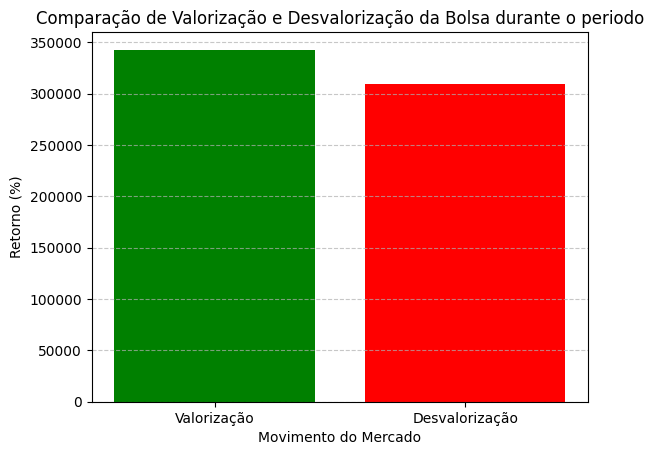

In [47]:
#plotando os dados
valores = [valorizacao, abs(desvalorizacao)]
rotulos = ["Valorização", "Desvalorização"]
plt.bar(rotulos, valores, color=["green", "red"])
plt.xlabel("Movimento do Mercado")
plt.ylabel("Retorno (%)")
plt.title("Comparação de Valorização e Desvalorização da Bolsa durante o periodo")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [48]:
#Calculando a valorização e a desvalorização por ano
valorizacao_por_ano = df[df["return (%)"] > 0].groupby("year")["return (%)"].sum()
desvalorizacao_por_ano = abs(df[df["return (%)"] < 0].groupby("year")["return (%)"].sum())

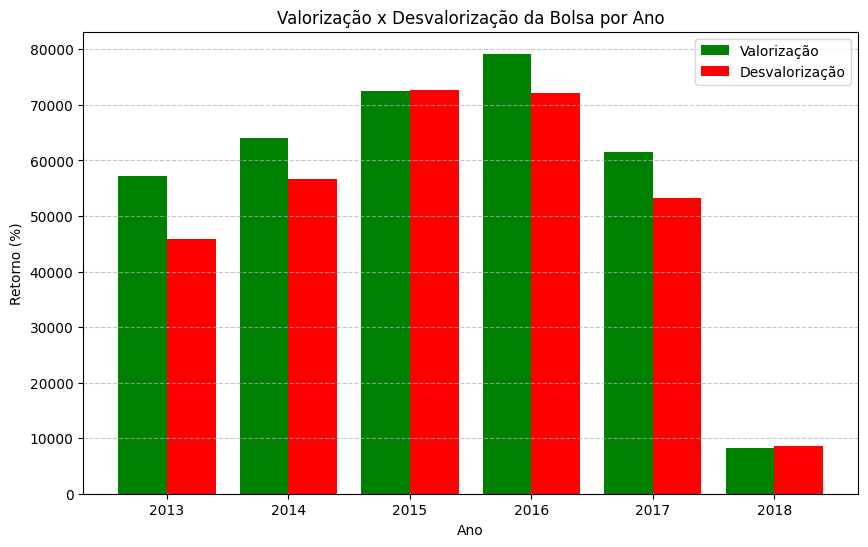

In [50]:
#Criando gráfico para comparar a valorização X desvalorização por ano
anos = valorizacao_por_ano.index

plt.figure(figsize=(10, 6))
plt.bar(anos - 0.4/2, valorizacao_por_ano, width=0.4, color='green', label='Valorização')
plt.bar(anos + 0.4/2, desvalorizacao_por_ano, width=0.4, color='red', label='Desvalorização')


plt.xlabel("Ano")
plt.ylabel("Retorno (%)")
plt.title("Valorização x Desvalorização da Bolsa por Ano")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)


plt.show()


In [51]:
#Calculando a valorização liquida do periodo
saldo_valorizacao = valorizacao_por_ano.sum() - desvalorizacao_por_ano.sum()
print(f"Valorização líquida do período: {saldo_valorizacao:.2f}%")

Valorização líquida do período: 33553.10%


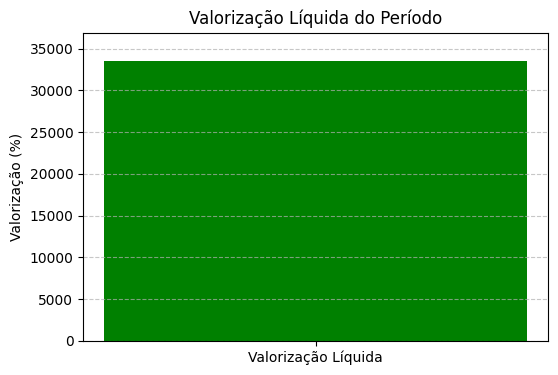

In [52]:
#Criando gráfico para visualizar a valorização liquida do periodo
saldo_valorizacao = valorizacao_por_ano.sum() - desvalorizacao_por_ano.sum()


plt.figure(figsize=(6, 4))
plt.bar(["Valorização Líquida"], [saldo_valorizacao], color="green")


plt.ylabel("Valorização (%)")
plt.title("Valorização Líquida do Período")
plt.ylim(0, saldo_valorizacao * 1.1)
plt.grid(axis="y", linestyle="--", alpha=0.7)


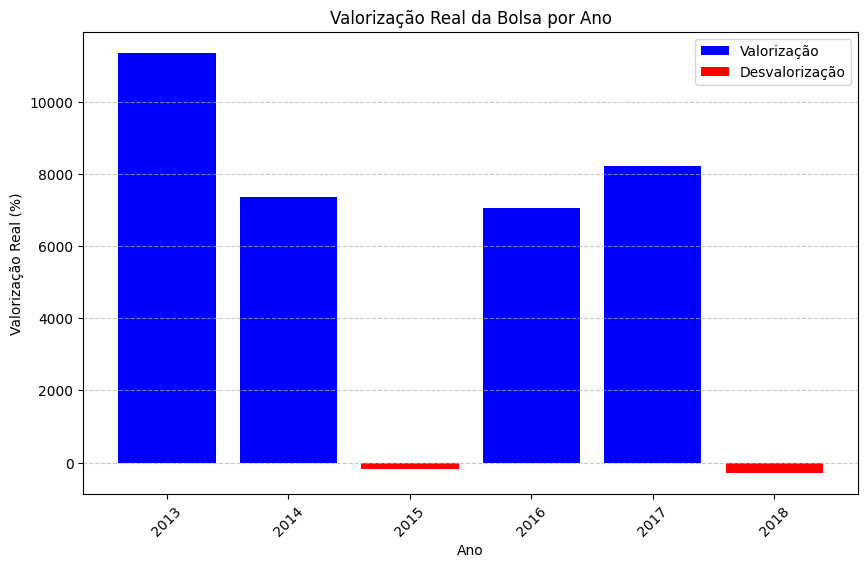

In [58]:
#Calculando a valorização real por ano
valorizacao_real_por_ano = valorizacao_por_ano - desvalorizacao_por_ano

#separando os dados positivos e negativos
valores_positivos = valorizacao_real_por_ano[valorizacao_real_por_ano >= 0]
valores_negativos = valorizacao_real_por_ano[valorizacao_real_por_ano < 0]

#criando a figura e o gráfico de barras
plt.figure(figsize=(10, 6))

#Barras azuis (valores positivos)
plt.bar(valores_positivos.index, valores_positivos, color='blue', label='Valorização')

#Barras vermelhas (valores negativos)
plt.bar(valores_negativos.index, valores_negativos, color='red', label='Desvalorização')

#Adicionando rótulos
plt.xlabel("Ano")
plt.ylabel("Valorização Real (%)")
plt.title("Valorização Real da Bolsa por Ano")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

#Exibindo o gráfico
plt.xticks(rotation=45)
plt.show()


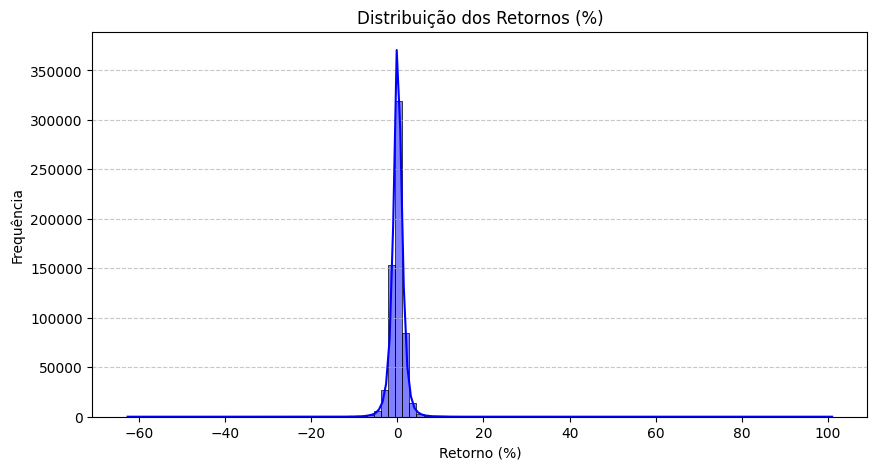

In [59]:
#Criando um gráfico histograma para análisar a distribuição dos retornos em porcentagem
plt.figure(figsize=(10, 5))

sns.histplot(df['return (%)'], bins=100, kde=True, color='blue')

plt.title('Distribuição dos Retornos (%)')
plt.xlabel('Retorno (%)')
plt.ylabel('Frequência')
plt.grid(axis="y", linestyle="--", alpha=0.7)



plt.show()

**Análise da Distribuição dos Retornos com Outliers**

De acordo com o histograma apresentado, observamos que a maior parte dos retornos diários está concentrada em torno de 0%, formando uma distribuição com alta densidade no centro e caudas longas.

Os principais pontos que podem ser destacados:

- A forma da curva evidencia que a maioria dos retornos diários são pequenos (positivos ou negativos), o que é esperado em mercados maduros.

- No entanto, há eventos extremos visíveis nas pontas da distribuição, indicando dias com retornos atípicos — tanto muito negativos quanto muito positivos.

- A presença desses outliers demonstra que, apesar de o mercado se comportar de maneira relativamente estável na maior parte do tempo, oscilações abruptas também ocorrem e precisam ser consideradas na gestão de risco.

Conclusão:
Embora a distribuição geral dos retornos seja centrada e estreita, a presença de outliers reforça a volatilidade implícita do mercado. Esses picos fora do padrão alertam para a necessidade de estratégias robustas de controle de risco, pois os eventos extremos podem impactar significativamente os resultados de uma carteira.

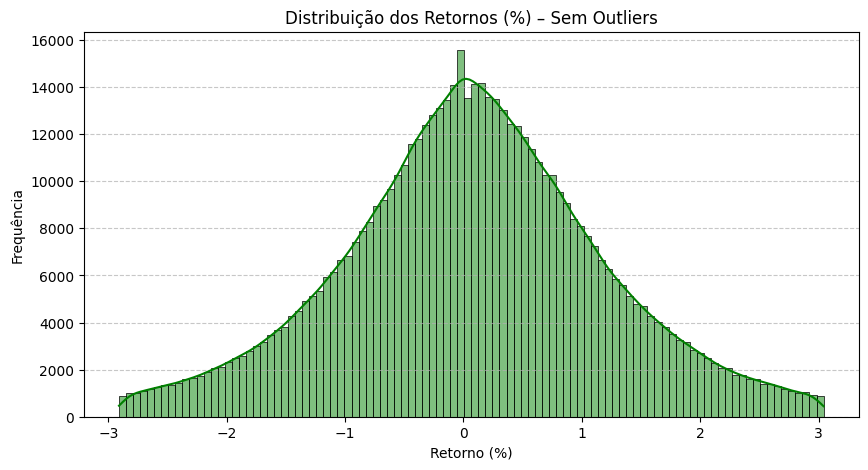

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

#Removendo os outliers usando o intervalo interquantil
Q1 = df['return (%)'].quantile(0.25)
Q3 = df['return (%)'].quantile(0.75)
IQR = Q3 - Q1

#Definindo limites para identificar outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrando os dados sem os outliers
df_sem_outliers = df[(df['return (%)'] >= limite_inferior) & (df['return (%)'] <= limite_superior)]

# Criando o histograma com KDE (curva de densidade)
plt.figure(figsize=(10, 5))
sns.histplot(df_sem_outliers['return (%)'], bins=100, kde=True, color='green')
plt.title('Distribuição dos Retornos (%) – Sem Outliers')
plt.xlabel('Retorno (%)')
plt.ylabel('Frequência')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


**Análise da Distribuição dos Retornos (%) – Sem Outliers**

Com a remoção dos outliers, o histograma mostra uma distribuição mais simétrica e concentrada dos retornos diários. A visualização evidencia melhor o comportamento típico do mercado, sem a influência de eventos extremos.

Pontos principais da análise:

- A maior parte dos retornos está distribuída entre -3% e +3%, o que demonstra uma baixa variação diária na maioria dos casos.

- A curva de densidade apresenta um formato semelhante ao de uma distribuição normal, o que pode indicar que, em condições normais de mercado, os retornos seguem um comportamento mais previsível.

- A simetria e o afunilamento da curva reforçam a ideia de que grandes oscilações são exceções, e que os retornos tendem a se concentrar próximos de zero.

Conclusão:
Ao excluir os outliers, é possível observar com maior clareza o comportamento real do mercado no dia a dia, evidenciando que ele opera de forma relativamente estável na maioria das vezes. Esse tipo de visualização é importante para análises mais realistas e para o desenvolvimento de estratégias baseadas em padrões estatísticos mais consistentes.



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


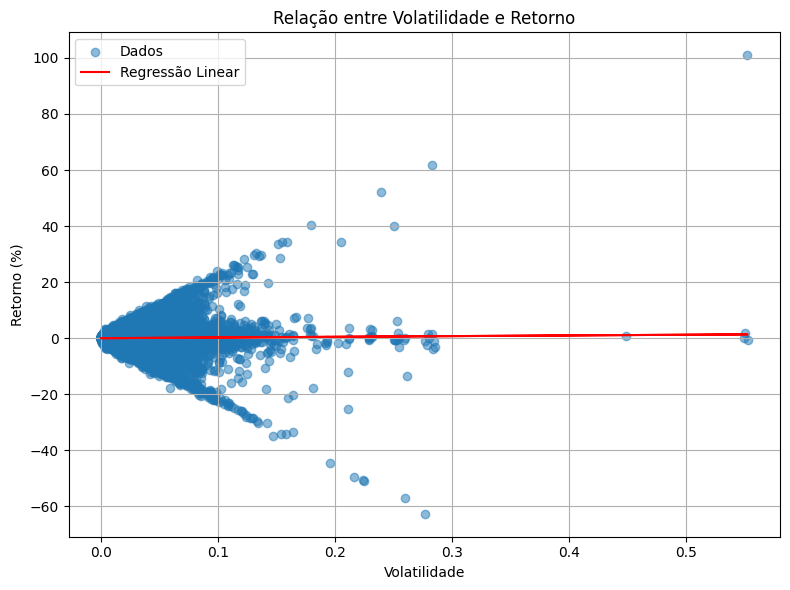

In [63]:
# Calculando variáveis para a regressão linear entre volatilidade e retorno
a, b = np.polyfit(df['volatility'], df['return (%)'], 1)
y = a * df['volatility'] + b

# Criando o gráfico de regressão linear
plt.figure(figsize=(8, 6))
plt.scatter(df['volatility'], df['return (%)'], label='Dados', alpha=0.5)
plt.plot(df['volatility'], y, 'r', label='Regressão Linear')
plt.xlabel("Volatilidade")
plt.ylabel("Retorno (%)")
plt.title("Relação entre Volatilidade e Retorno")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [64]:
#Verificando o ajuste da reta aos dados
np.linalg.norm(df['return (%)'] - y)

np.float64(1255.5420607724661)

In [65]:
r2 = r2_score(df['return (%)'], y)
print(f'R²: {r2}')


R²: 0.0002103452986101928


**Análise da Relação entre Volatilidade e Retorno**

De acordo com o gráfico de regressão linear, observamos que os dados estão bastante dispersos e não seguem um padrão claro.  
Os principais indicadores confirmam essa falta de relação entre as variáveis:  

- O erro (Norma) foi alto (1224.28), indicando que a reta de regressão não se ajusta bem aos dados.  
- O coeficiente de determinação (R²) foi muito baixo (0.00026), mostrando que a volatilidade não explica a variação dos retornos.  
- A reta de regressão não apresenta inclinação significativa, reforçando a ausência de uma relação linear entre as variáveis.  

Conclusão:  
A volatilidade dos ativos **não tem impacto significativo sobre os retornos**, sugerindo que outros fatores podem ser mais relevantes na determinação dos retornos dos ativos analisados.  

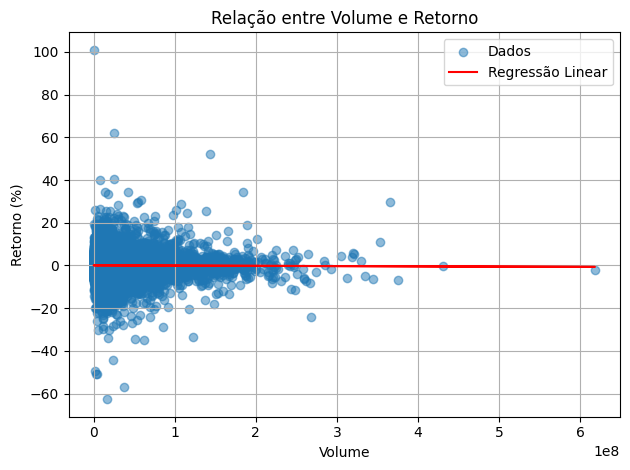

In [66]:
#Criando um gráfico de regressão linear para ver a relação de volume X retorno
a_volume, b_volume = np.polyfit(df['volume'], df['return (%)'], 1)
y_volume = a_volume * df['volume'] + b_volume

#Criando o gráfico de regressão
plt.scatter(df['volume'], df['return (%)'], label='Dados', alpha=0.5)
plt.plot(df['volume'], y_volume, 'r', label='Regressão Linear')
plt.xlabel("Volume")
plt.ylabel("Retorno (%)")
plt.title("Relação entre Volume e Retorno")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [67]:
#Verificando o ajuste da reta aos dados
np.linalg.norm(df['return (%)'] - y_volume)

np.float64(1255.6487481870793)

In [68]:
r2 = r2_score(df['return (%)'], y)
print(f'R²: {r2}')


R²: 0.0002103452986101928


**Análise da Relação entre Volume e Retorno**
<br>

De acordo com o gráfico de regressão linear, observamos que os dados estão altamente dispersos e não indicam uma tendência clara entre o volume negociado e o retorno dos ativos. A dispersão dos pontos e a inclinação quase nula da reta reforçam essa percepção.

Os principais indicadores estatísticos corroboram essa conclusão:

- O erro (Norma) foi alto (1263.07), indicando que a reta de regressão não se ajusta bem aos dados.

- O coeficiente de determinação (R²) foi extremamente baixo (0.0002), evidenciando que o volume não explica a variação dos retornos.
- A reta de regressão apresenta inclinação praticamente nula, o que mostra a ausência de uma relação linear significativa entre as variáveis.

Conclusão:
O volume negociado dos ativos não tem impacto significativo sobre seus retornos. Isso sugere que outros fatores, como fundamentos econômicos, notícias de mercado ou indicadores técnicos, podem ter maior influência na valorização ou desvalorização dos ativos analisados.

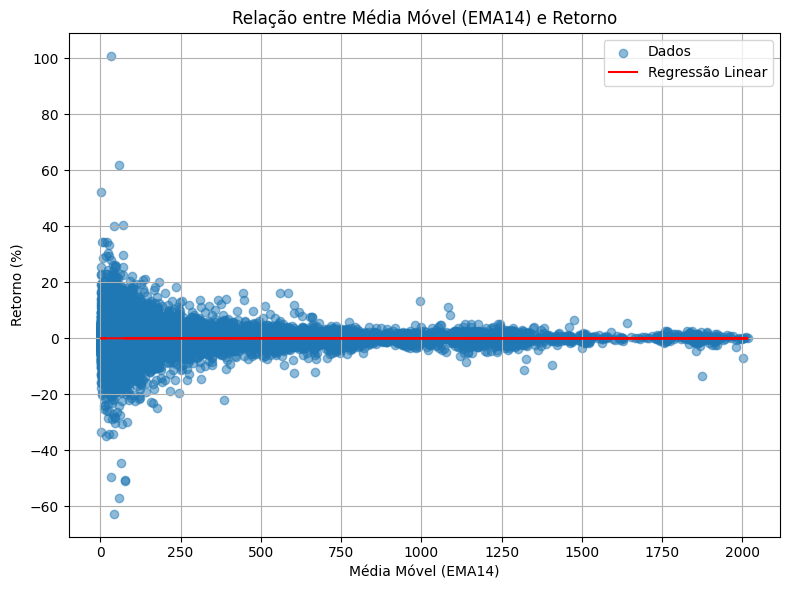

In [69]:
# Verificando a relação de Média Móvel (EMA10) X Retorno
a_ema, b_ema = np.polyfit(df['EMA14'], df['return (%)'], 1)
y_ema = a_ema * df['EMA14'] + b_ema

# Criando o gráfico de regressão
plt.figure(figsize=(8, 6))
plt.scatter(df['EMA14'], df['return (%)'], label='Dados', alpha=0.5)
plt.plot(df['EMA14'], y_ema, 'r', label='Regressão Linear')
plt.xlabel("Média Móvel (EMA14)")
plt.ylabel("Retorno (%)")
plt.title("Relação entre Média Móvel (EMA14) e Retorno")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [70]:
#Verificando o ajuste da reta aos dados
np.linalg.norm(df['return (%)'] - y_ema)

np.float64(1255.6734442610978)

In [71]:
r2 = r2_score(df['return (%)'], y_ema)
print(f'R²: {r2}')


R²: 1.0926904162600337e-06


**Análise da Relação entre Média Móvel e Retorno**

A análise do gráfico de regressão linear entre a média móvel (EMA10) e o retorno dos ativos revela uma dispersão acentuada dos dados, sem uma tendência linear perceptível. A reta de regressão, com inclinação praticamente nula, evidencia a ausência de uma relação direta entre as variáveis.

Os principais indicadores estatísticos confirmam essa observação:

- O erro (Norma) foi alto (1263.10), o que mostra que a reta de regressão não se ajusta bem aos dados observados.

- O coeficiente de determinação (R²) foi praticamente zero (0.0000002854), indicando que a média móvel não contribui para explicar a variação dos retornos.

- A inclinação da reta de regressão é muito baixa, reforçando a inexistência de uma relação linear significativa.

Conclusão:
A média móvel EMA10 não apresenta influência relevante sobre os retornos dos ativos analisados. Isso sugere que, isoladamente, esse indicador técnico não é eficaz para prever variações nos retornos, sendo necessário considerar outras variáveis ou estratégias combinadas para obter insights mais consistentes.

<Axes: xlabel='diff_close_ema14', ylabel='return (%)'>

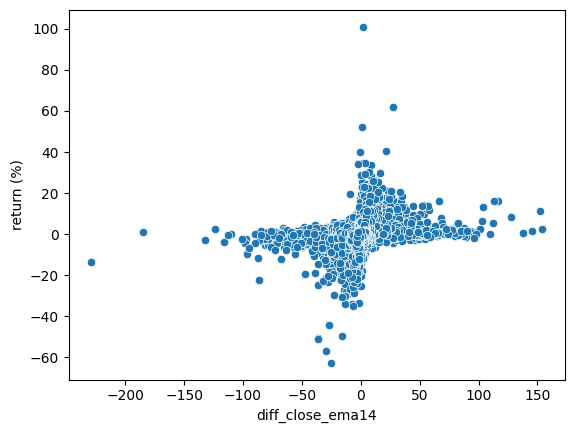

In [72]:
#Plotando a relação entre a diferença de close e o preço de fechamento com o retorno
sns.scatterplot(x='diff_close_ema14', y='return (%)', data=df)


**Análise da Relação entre a Diferença do Preço de Fechamento e a EMA10 com o Retorno**

O gráfico de dispersão mostra a relação entre a diferença do preço de fechamento em relação à média móvel exponencial de 10 períodos (EMA10) e o retorno percentual dos ativos.

Apesar da expectativa de que desvios significativos em relação à média poderiam sinalizar retornos futuros mais altos ou mais baixos, os dados não evidenciam uma relação clara entre essas variáveis. As observações estão concentradas em torno de zero (quando o preço está próximo da EMA10), com dispersões semelhantes tanto para valores positivos quanto negativos da diferença.

Os principais pontos observados:

- Os dados se concentram fortemente em torno do eixo X = 0, com alta variabilidade dos retornos, mesmo para pequenas diferenças.

- Não há uma tendência de retorno mais positivo ou negativo conforme o preço se afasta da EMA10.

- O gráfico mostra retornos positivos e negativos distribuídos de forma aleatória, tanto quando o preço está acima quanto abaixo da média.

Conclusão:
A diferença entre o preço de fechamento e a média móvel EMA10 não apresenta uma relação linear significativa com os retornos. Isso sugere que o simples fato de o preço estar acima ou abaixo da média não é suficiente, por si só, para prever o comportamento do retorno. Outros fatores podem estar influenciando o desempenho dos ativos e devem ser considerados em análises mais robustas.




<Axes: xlabel='volume', ylabel='return'>

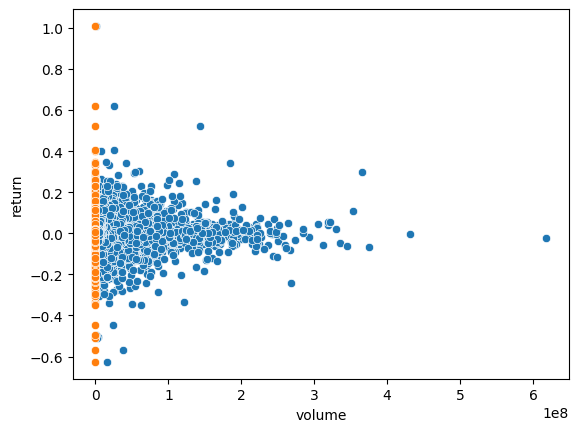

In [74]:
#Criando um gráfico de dispersão para analisar a relação entre o volume de negociações e o retorno percentual
sns.scatterplot(x='volume', y='return', data=df)
#Criando um gráfico de dispersão para analisar a relação entre a volatilidade dos ativos e o retorno percentual
sns.scatterplot(x='volatility', y='return', data=df)

**Análise da Relação entre o Volume e a Volatilidade com o Retorno**

O gráfico de dispersão mostra a relação entre duas variáveis — o volume negociado e a volatilidade dos preços — com o retorno percentual dos ativos.

A expectativa era de que ativos com maior volume ou maior volatilidade pudessem apresentar retornos mais elevados ou, ao menos, indicar alguma tendência clara. No entanto, os dados analisados não evidenciam uma relação visual direta ou linear entre essas variáveis.

**Principais pontos observados:**

*Volume vs Retorno:*

- A maioria dos dados está concentrada em volumes baixos, mas mesmo assim apresentam uma grande variabilidade nos retornos.

- Não há uma tendência visível de que volumes mais altos estejam associados a maiores ou menores retornos.

- Retornos positivos e negativos ocorrem de forma aleatória ao longo de toda a faixa de volume negociado.

*Volatilidade vs Retorno:*

- Assim como o volume, a volatilidade também não apresenta uma relação clara com os retornos.

- Observa-se que ativos com diferentes níveis de volatilidade apresentam retornos dispersos, tanto positivos quanto negativos.

- Não se observa uma tendência crescente ou decrescente entre a volatilidade e o retorno.

Conclusão:
Tanto o volume quanto a volatilidade não apresentam uma relação linear significativa com os retornos dos ativos. Isso indica que, de forma isolada, essas variáveis não são suficientes para prever o comportamento futuro dos preços.

Assim como na análise da diferença entre o preço de fechamento e a EMA10, os resultados sugerem que a movimentação dos retornos pode depender de um conjunto mais amplo de fatores, exigindo análises complementares com múltiplas variáveis e abordagens estatísticas mais sofisticadas.

<Axes: xlabel='log_volume', ylabel='return'>

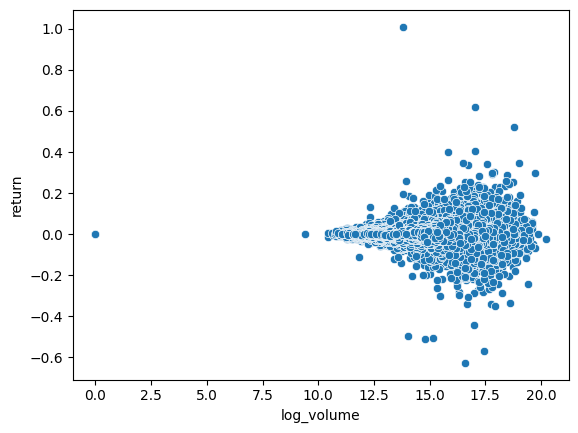

In [75]:
#Em seguida, criei um gráfico de dispersão para visualizar se existe alguma relação entre o volume transformado e o retorno dos ativos
sns.scatterplot(x='log_volume', y='return', data=df)

**Análise da Relação entre o Volume (Transformado com Logaritmo) e o Retorno**

O gráfico de dispersão acima mostra a relação entre o volume de negociações (após transformação logarítmica com log1p) e o retorno dos ativos. A transformação foi aplicada com o objetivo de suavizar os efeitos de valores extremos e tornar a distribuição do volume mais uniforme.

Mesmo após essa normalização, o gráfico indica que não há uma relação linear clara entre o volume (em escala logarítmica) e o retorno.

Principais pontos observados:

- A maioria dos pontos se concentra entre os valores de log_volume de 15 a 18, o que representa o intervalo mais comum de volumes negociados.

- Os retornos continuam amplamente distribuídos ao redor do zero, com grande dispersão, independentemente do volume.

- Não há indícios de que volumes maiores ou menores estejam associados sistematicamente a retornos positivos ou negativos.

Conclusão:

Apesar da transformação logarítmica ajudar a visualizar melhor os dados, o volume de negociações (em escala logarítmica) não apresenta uma correlação evidente com os retornos. Essa análise sugere que o volume, por si só, pode não ser um preditor confiável de retorno, sendo necessário considerar outros fatores ou realizar análises multivariadas mais complexas.

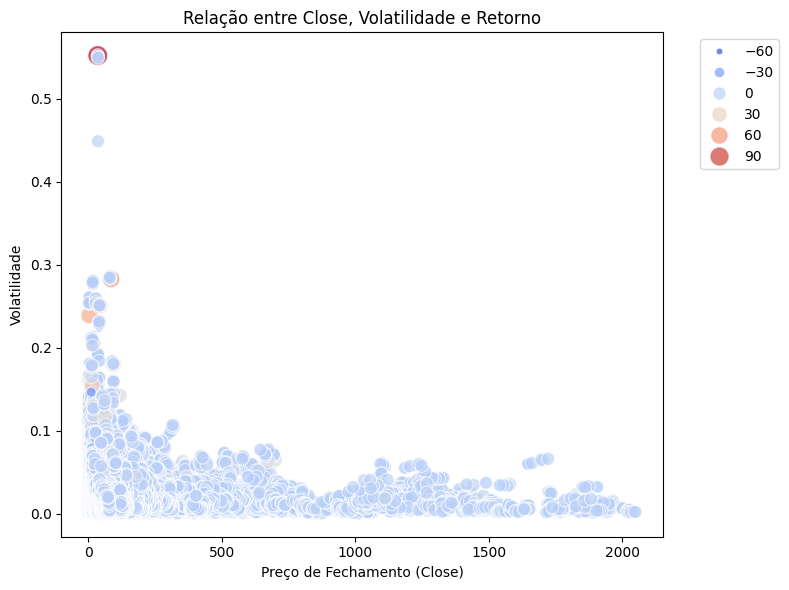

In [76]:
#Verificando a relação de preço e volatilidade X retorno
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x='close',
    y='volatility',
    hue='return (%)',
    palette='coolwarm',
    size='return (%)',
    sizes=(20, 200),
    alpha=0.7
)
plt.title("Relação entre Close, Volatilidade e Retorno")
plt.xlabel("Preço de Fechamento (Close)")
plt.ylabel("Volatilidade")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.tight_layout()
plt.show()


**Análise da Relação entre Preço de Fechamento, Volatilidade e Retorno**

O gráfico de dispersão apresenta a relação entre o preço de fechamento dos ativos (Close), a volatilidade e o retorno percentual. Cada ponto representa um ativo, sendo sua cor e tamanho proporcionais ao retorno (%).


Observações principais:

- A maioria dos ativos com alta volatilidade está concentrada nos preços mais baixos.

- À medida que o preço de fechamento aumenta, a volatilidade tende a diminuir, indicando que ativos mais caros tendem a ser menos voláteis.

- A variação nos retornos está distribuída de forma ampla, com maior concentração em ativos com preços menores.

- O tamanho e a coloração dos pontos reforçam que os maiores retornos (positivos e negativos) ocorrem principalmente entre os ativos com menor preço e maior volatilidade.
<br>

**Relação Risco x Retorno:**

O gráfico evidencia a clássica relação de risco x retorno. Ativos com preços mais baixos e alta volatilidade carregam maior risco, e com isso, também possuem maior potencial para retornos expressivos — tanto positivos quanto negativos. Isso significa que, embora não seja possível prever a direção (se o preço vai subir ou cair), é possível observar que o impacto no retorno tende a ser mais intenso nesses ativos.
<br>
<br>
Conclusão:
Existe uma tendência de que ativos mais baratos e voláteis apresentem uma variação maior nos retornos, o que reforça a importância de considerar o risco associado ao se avaliar oportunidades de investimento. O preço e a volatilidade não determinam o retorno, mas exercem influência sobre sua magnitude — podendo resultar em lucros expressivos ou prejuízos significativos. Portanto, é essencial equilibrar risco e retorno na tomada de decisão.

<ipython-input-83-a0fbf5867396>:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df.pivot_table(


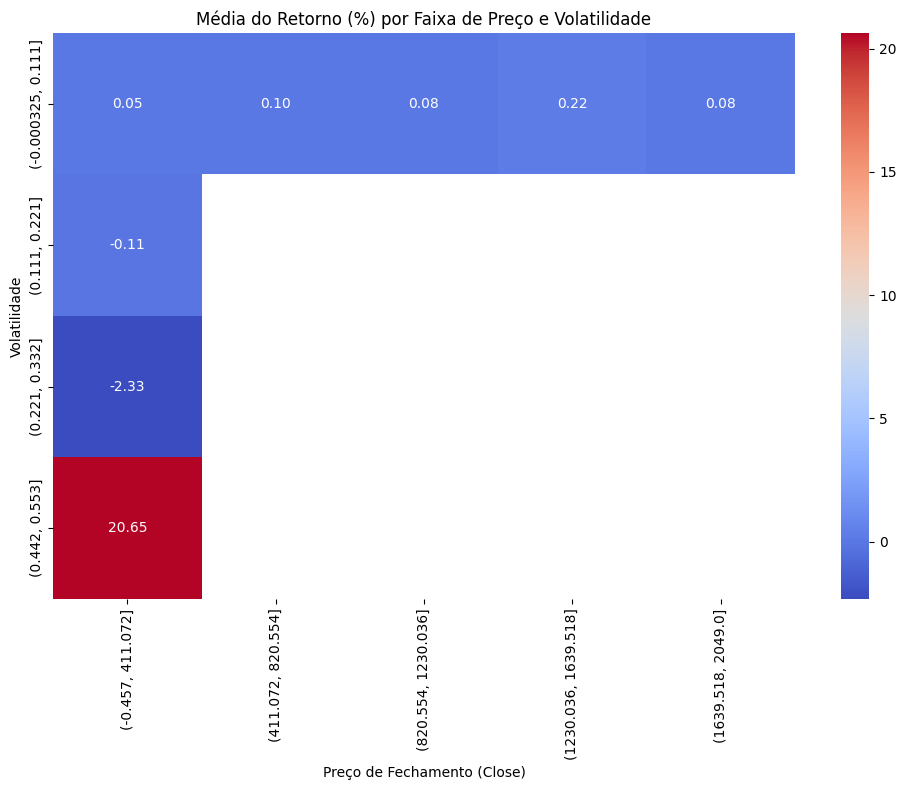

In [83]:
#Criando feature: Binando os dados
df['close_bin'] = pd.cut(df['close'], bins=5)
df['volatility_bin'] = pd.cut(df['volatility'], bins=5)

#Criando uma tabela de médias de retorno por faixa
pivot_table = df.pivot_table(
    index='volatility_bin',
    columns='close_bin',
    values='return (%)',
    aggfunc='mean'
)

#Criando o heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Média do Retorno (%) por Faixa de Preço e Volatilidade")
plt.xlabel("Preço de Fechamento (Close)")
plt.ylabel("Volatilidade")
plt.tight_layout()
plt.show()


**Média do Retorno (%) por Faixa de Preço e Volatilidade**

O heatmap mostra a média dos retornos percentuais dos ativos, considerando faixas específicas de preço de fechamento e volatilidade. As cores variam conforme a média de retorno: tons mais quentes indicam maiores retornos, enquanto tons frios indicam menores retornos (ou até negativos).
<br>
<br>
Observações principais:

- Ativos com alta volatilidade e preço baixo apresentaram o maior retorno médio (20.65%), mas também representam maior risco, como visto anteriormente.

- Conforme a volatilidade diminui, os retornos médios tendem a estabilizar, permanecendo próximos de zero.

- A combinação de baixa volatilidade com qualquer faixa de preço resulta em retornos médios baixos, reforçando a ideia de que menor risco tende a gerar menor retorno.

Conclusão: O gráfico reforça a clássica relação risco x retorno — quanto maior a volatilidade, maior o potencial de retorno (ou prejuízo). O preço e a volatilidade influenciam diretamente o comportamento médio dos retornos, mostrando que essas variáveis não determinam se o ativo irá subir ou cair, mas indicam o potencial de variação que ele pode ter.

In [84]:
#Calcular a mediana da volatilidade
vol_mediana = df['volatility'].median()

#Criando feature e Separando os dados
grupo_baixa_vol = df[df['volatility'] <= vol_mediana]
grupo_alta_vol = df[df['volatility'] > vol_mediana]

#Calculando a média dos retornos
media_baixa_vol = grupo_baixa_vol['return'].mean()
media_alta_vol = grupo_alta_vol['return'].mean()

print("Média de retorno (baixa volatilidade):", media_baixa_vol)
print("Média de retorno (alta volatilidade):", media_alta_vol)


Média de retorno (baixa volatilidade): 0.0005924224422960083
Média de retorno (alta volatilidade): 0.0005032336584079899


In [85]:
#Usando K-means para agrupar os dados
X = df[['close', 'volatility', 'return']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [86]:
kmeans = KMeans(n_clusters=3, random_state=42)  #3 clusters
df['cluster'] = kmeans.fit_predict(X_scaled)


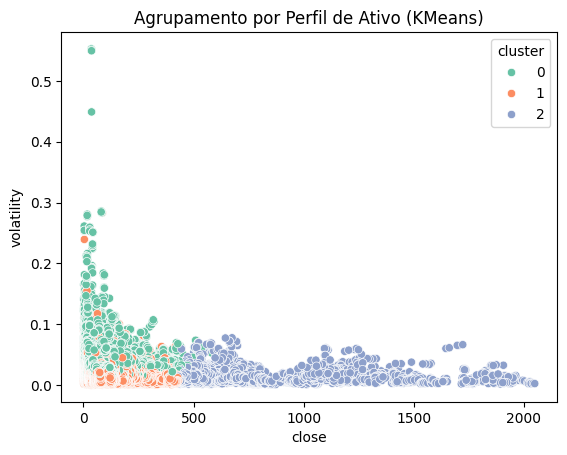

In [87]:
#Plotando o resultado do kmeans
sns.scatterplot(x='close', y='volatility', hue='cluster', data=df, palette='Set2')
plt.title('Agrupamento por Perfil de Ativo (KMeans)')
plt.show()

**Agrupamento por Perfil de Ativo com K-Means**

O gráfico acima apresenta a segmentação dos ativos em três grupos distintos, realizada através do algoritmo de agrupamento K-Means, com base nas variáveis preço de fechamento (close) e volatilidade.

Esse tipo de abordagem permite identificar padrões de comportamento entre os ativos, agrupando aqueles que compartilham características semelhantes. A seguir, a interpretação de cada grupo identificado:

- Grupo 0 – Alta Volatilidade e Baixo Preço
Ativos com preços mais baixos e alta volatilidade. Esse grupo apresenta o maior risco, com forte oscilação nos preços e possibilidade de retornos extremos — tanto positivos quanto negativos. São ativos especulativos, muitas vezes associados a maiores incertezas de mercado.

- Grupo 1 – Perfil Equilibrado
Ativos com preço e volatilidade intermediários. Este grupo representa uma zona de equilíbrio, reunindo ativos que combinam certa estabilidade com potencial de valorização. Podem ser interessantes para estratégias mais balanceadas, com risco moderado.

- Grupo 2 – Preço Alto e Volatilidade Reduzida
Ativos com preço de fechamento elevado e volatilidade mais controlada. São geralmente ativos mais consolidados, com menor risco e comportamento mais previsível. Ideal para perfis conservadores ou estratégias de longo prazo que buscam estabilidade.



In [92]:
#Adicionando o cluster no dataset
df['cluster'] = kmeans.labels_
df

,date,open,high,low,close,volume,Name,year,day_of_week,month,...,return (%),return_shifted,RSI_14,volatility,diff_close_ema14,log_volume,target,close_bin,volatility_bin,cluster
13,2013-02-28,13.49,13.63,13.39,13.43,6143600,AAL,2013,3,2,...,0.149142,1.131222,35.067873,0.024135,-0.345192,15.630922,1,"(-0.457, 411.072]","(-0.000325, 0.111]",0
14,2013-03-01,13.37,13.95,13.32,13.61,7376800,AAL,2013,4,3,...,1.340283,0.149142,37.608696,0.023922,-0.143167,15.813851,1,"(-0.457, 411.072]","(-0.000325, 0.111]",1
15,2013-03-04,13.50,14.07,13.47,13.90,8174800,AAL,2013,0,3,...,2.130786,1.340283,43.913043,0.007646,0.127256,15.916567,1,"(-0.457, 411.072]","(-0.000325, 0.111]",1
16,2013-03-05,14.01,14.05,13.71,14.05,7676100,AAL,2013,1,3,...,1.079137,2.130786,47.587719,0.007078,0.240288,15.853622,1,"(-0.457, 411.072]","(-0.000325, 0.111]",1
17,2013-03-06,14.52,14.68,14.25,14.57,13243200,AAL,2013,2,3,...,3.701068,1.079137,49.040512,0.013330,0.658916,16.398995,1,"(-0.457, 411.072]","(-0.000325, 0.111]",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS,2018,3,2,...,1.420566,-2.067645,64.912281,0.015148,0.530466,14.908192,0,"(-0.457, 411.072]","(-0.000325, 0.111]",1
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS,2018,4,2,...,-1.336417,1.420566,56.278229,0.013224,-0.441596,14.769170,0,"(-0.457, 411.072]","(-0.000325, 0.111]",1
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS,2018,0,2,...,-3.842146,-1.336417,43.835616,0.019033,-2.939383,14.901386,0,"(-0.457, 411.072]","(-0.000325, 0.111]",0
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS,2018,1,2,...,-0.758499,-3.842146,36.742424,0.019201,-3.032799,15.409698,1,"(-0.457, 411.072]","(-0.000325, 0.111]",0


In [93]:
#Calculando a média de retorno de cada grupo
df.groupby('cluster')['return'].mean()

,return
cluster,
0,-0.015525
1,0.003794
2,0.001189


Ao agrupar os ativos com base em seu perfil de preço e volatilidade, observamos as seguintes médias de retorno:


- Preço baixo e alta volatilidade: apresentou o pior desempenho médio, com retorno negativo de -1,55%, refletindo o alto risco associado a esse perfil.

- Preço baixo e baixa volatilidade: teve o melhor desempenho médio, com retorno positivo de 0,37%, indicando um bom equilíbrio entre risco e retorno.

- Preço alto e baixa volatilidade: obteve retorno positivo de 0,11%, mostrando estabilidade, mas com menor potencial de ganho.

Esses resultados reforçam a importância de considerar o perfil de risco dos ativos ao compor uma carteira, especialmente para quem busca retorno ajustado ao risco.

In [96]:
#Mostrando qual grupo teve o pior retorno
df.groupby('cluster')['return'].min()

,return
cluster,
0,-0.626183
1,-0.033210
2,-0.135197


**Pior Retorno Observado por Grupo**

Ao analisarmos o pior retorno individual dentro de cada grupo, temos os seguintes resultados:

- Preço baixo e alta volatilidade: registrou o pior desempenho isolado, com um retorno mínimo de -62,61%, evidenciando o risco elevado desse perfil.

- Preço alto e baixa volatilidade: teve um retorno mínimo de -13,51%, também com quedas relevantes, apesar do perfil mais estável.

- Preço baixo e baixa volatilidade: apresentou o menor risco de queda, com retorno mínimo de -3,32%, sendo o grupo com maior proteção contra perdas severas.

Esses dados reforçam como a combinação entre preço e volatilidade impacta diretamente o risco extremo de um ativo.

In [95]:
#Mostrando qual grupo teve o maior retorno
df.groupby('cluster')['return'].max()

,return
cluster,
0,1.009513
1,0.619066
2,0.162584


Ao analisarmos o maior retorno obtido dentro de cada grupo, os resultados foram:

- Preço baixo e alta volatilidade: apresentou o maior retorno individual entre os grupos, atingindo +100,95%, o que reforça seu potencial de valorização, apesar do risco elevado.

- Preço baixo e baixa volatilidade: teve um retorno máximo de +61,90%, combinando bons ganhos com maior estabilidade.

- Preço alto e baixa volatilidade: registrou o menor retorno máximo, com +16,26%, refletindo seu perfil mais conservador e previsível.

Esses dados ilustram a clássica relação risco-retorno: ativos mais voláteis (Grupo 0) oferecem maiores oportunidades de ganho, mas também maior exposição a perdas.



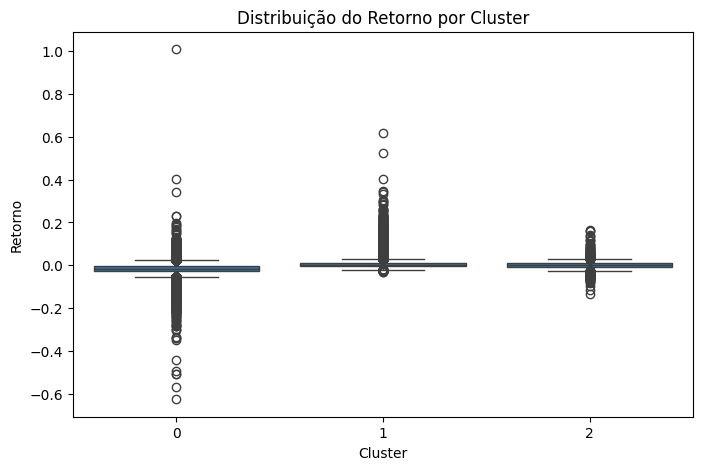

In [99]:
#Plotando a distribuição de retorno por cada grupo
plt.figure(figsize=(8,5))
sns.boxplot(x=df['cluster'], y=df['return'])
plt.title("Distribuição do Retorno por Cluster")
plt.xlabel("Cluster")
plt.ylabel("Retorno")
plt.show()


Adicionar legenda

##Tratando outliers

In [100]:
df.describe()

,date,open,high,low,close,volume,year,day_of_week,month,days_since_start,...,rolling_std_14,return,return (%),return_shifted,RSI_14,volatility,diff_close_ema14,log_volume,target,cluster
count,612475,612475.000000,612475.000000,612475.000000,612475.000000,6.124750e+05,612475.000000,612475.000000,612475.000000,612475.000000,...,612475.000000,612475.000000,612475.000000,612475.000000,612475.000000,612475.000000,612475.000000,612475.000000,612475.000000,612475.000000
mean,2015-08-27 06:52:04.245724416,83.287880,84.045286,82.518694,83.308555,4.311839e+06,2015.146814,2.018703,6.602749,930.286160,...,1.625599,0.000548,0.054783,0.056144,53.210882,0.013030,0.281631,14.616317,0.520856,0.844511
min,2013-02-28 00:00:00,1.620000,1.690000,1.500000,1.590000,0.000000e+00,2013.000000,0.000000,1.000000,20.000000,...,0.012514,-0.626183,-62.618262,-62.618262,0.000000,0.000227,-228.960456,0.000000,0.000000,0.000000
25%,2014-06-04 00:00:00,40.360000,40.760000,39.980000,40.390000,1.069442e+06,2014.000000,1.000000,4.000000,481.000000,...,0.609012,-0.006781,-0.678104,-0.677074,41.209830,0.007353,-0.583895,13.882649,0.000000,1.000000
50%,2015-09-01 00:00:00,62.800000,63.370000,62.220000,62.820000,2.078667e+06,2015.000000,2.000000,7.000000,935.000000,...,1.031477,0.000634,0.063412,0.064352,53.293413,0.010852,0.214153,14.547238,1.000000,1.000000
75%,2016-11-18 00:00:00,94.670000,95.490000,93.866350,94.700000,4.274966e+06,2016.000000,3.000000,10.000000,1379.000000,...,1.783295,0.008098,0.809775,0.811359,65.431683,0.015988,1.077360,15.268287,1.000000,1.000000
max,2018-02-07 00:00:00,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08,2018.000000,4.000000,12.000000,1825.000000,...,124.101573,1.009513,100.951315,100.951315,100.000000,0.552558,153.848155,20.242383,1.000000,2.000000
std,NaN,97.695151,98.526482,96.821723,97.706097,8.655534e+06,1.437162,1.398877,3.414018,521.215926,...,2.546971,0.016045,1.604476,1.604468,16.956442,0.009436,3.282641,1.062124,0.499565,0.391696


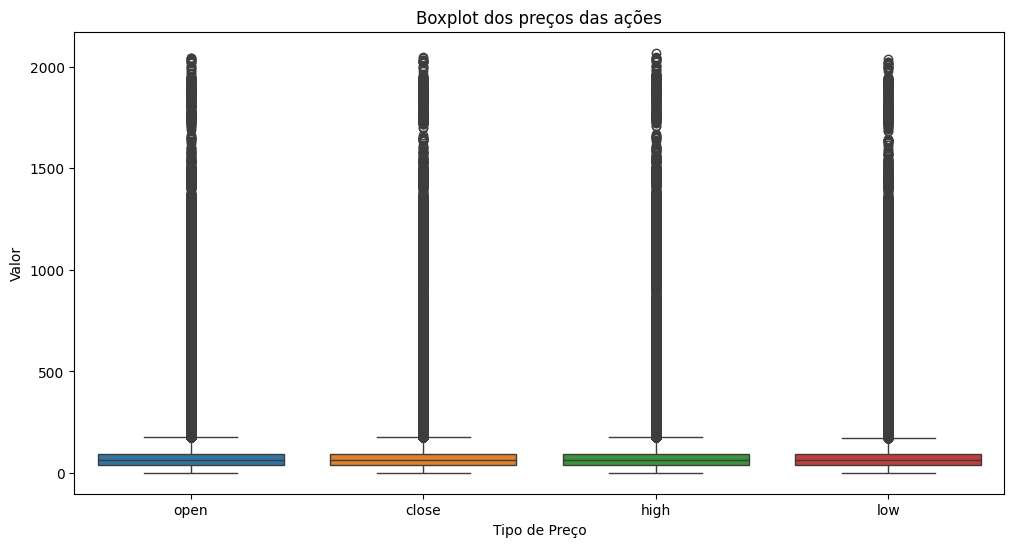

In [101]:
# Criar a figura
plt.figure(figsize=(12,6))

# Criar boxplot para todas as colunas de preço
sns.boxplot(data=df[['open', 'close', 'high', 'low']])

# Ajustando rótulos
plt.title('Boxplot dos preços das ações')
plt.xlabel('Tipo de Preço')
plt.ylabel('Valor')

plt.show()

In [102]:
#Calculando os intervalos interquantis
q1_open = df['open'].quantile(0.25)
q3_open = df['open'].quantile(0.75)
iqr_open = q3_open - q1_open

q1_close = df['close'].quantile(0.25)
q3_close = df['close'].quantile(0.75)
iqr_close = q3_close - q1_close

q1_high = df['high'].quantile(0.25)
q3_high = df['high'].quantile(0.75)
iqr_high = q3_high - q1_high

q1_low = df['low'].quantile(0.25)
q3_low = df['low'].quantile(0.75)
iqr_low = q3_low - q1_low


In [103]:
#Usando o metodo de  winsorizing para tratar os outliers
def winsorizing_outlier(dataset, column, q1, q3, iqr):
    if dataset[column] < q1 - 1.5 * iqr:
        return q1 - 1.5 * iqr
    elif dataset[column] > q3 + 1.5 * iqr:
        return q3 + 1.5 * iqr
    else:
        return dataset[column]


In [104]:
#Aplicando metodo de winsorizing, consiste em substituir o outlier acima da média para
#O maior valor permitido pelo intervalo interquantil, e o outlier abaixo da média para
#O valor minimo permitido pelo intervalo interquantil
cols = ['open', 'close', 'high', 'low']
q1 = {col: df[col].quantile(0.25) for col in cols}
q3 = {col: df[col].quantile(0.75) for col in cols}
iqr = {col: q3[col] - q1[col] for col in cols}

for col in cols:
    df[col] = df.apply(lambda x: winsorizing_outlier(x, col, q1[col], q3[col], iqr[col]), axis=1)


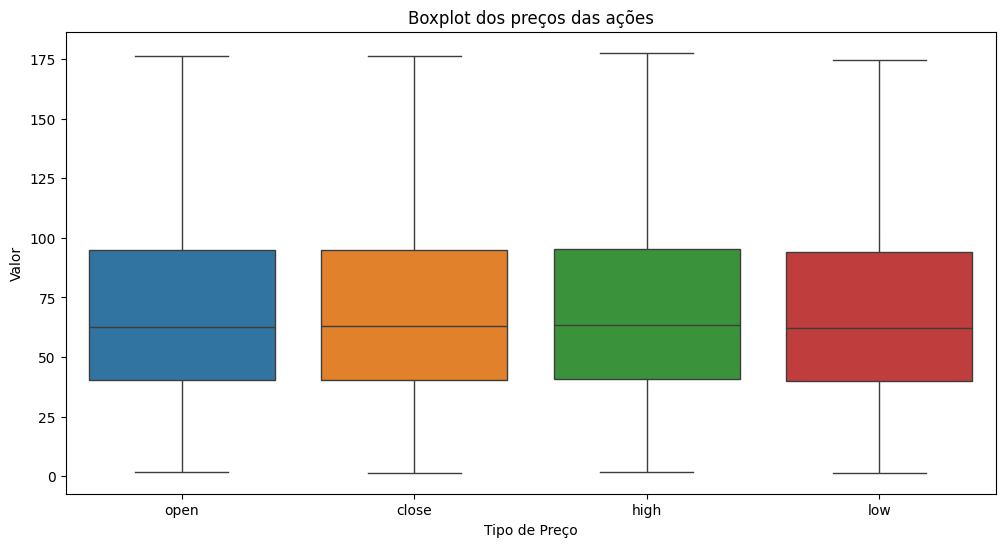

In [105]:
#Criando a figura
plt.figure(figsize=(12,6))

#Criando boxplot para as colunas de preço
sns.boxplot(data=df[['open', 'close', 'high', 'low']])

#Ajustando rótulos
plt.title('Boxplot dos preços das ações')
plt.xlabel('Tipo de Preço')
plt.ylabel('Valor')

plt.show()

Após tratar os outliers, irei rodar novamente a seção da criação de features, ja que alguns dados foram afetados

##Criando modelo

In [119]:
df.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'Name', 'year',
       'day_of_week', 'month', 'days_since_start', 'EMA14', 'rolling_mean_5',
       'rolling_std_5', 'rolling_mean_14', 'rolling_std_14', 'return',
       'return (%)', 'return_shifted', 'RSI_14', 'volatility',
       'diff_close_ema14', 'log_volume', 'target', 'close_bin',
       'volatility_bin', 'cluster'],
      dtype='object')

In [126]:
#Decidindo quais colunas serão usadas para o modelo
features = [
    'open', 'close', 'high', 'low', 'volume',
    'volatility', 'EMA14',
    'day_of_week', 'month', 'days_since_start',
    'year','return_shifted','cluster','rolling_mean_5',
       'rolling_std_5', 'rolling_mean_14', 'rolling_std_14','RSI_14'
]

X = df[features]
y = df['target']


In [127]:
#Separando os dados em 80% treinos e 20% testes
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [128]:
from sklearn.ensemble import RandomForestClassifier

#Criando e treinando o modelo
modelo = RandomForestClassifier(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [129]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = modelo.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[17175 10405]
 [ 8680 20855]]
              precision    recall  f1-score   support

           0       0.66      0.62      0.64     27580
           1       0.67      0.71      0.69     29535

    accuracy                           0.67     57115
   macro avg       0.67      0.66      0.66     57115
weighted avg       0.67      0.67      0.67     57115

